In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [62]:
# ============================================================
# 1. Load dataset
# ============================================================
df = pd.read_csv('/content/drive/MyDrive/datasets asah/clean/final_datsest_v0-2.csv', index_col=0)
df.head()

,avg_study_duration,total_study_duration,total_revisit,total_tutorial_completion,enrolling_times,avg_total_course_completion_duration,avg_submission_rating,max_score,average_score,total_attemps,is_passed,avg_duration,avg_time_left,avg_time_utilization,dominant_days,consistency_ratio,total_events
developer_id,,,,,,,,,,,,,,,,,
3390,143756.595087,4.588711e+08,714,3192,61.0,54.960000,4.064833,100.0,79.831190,622.0,450.0,0 days 00:06:22.668810289,0 days 00:05:31.639871382,56.309396,['Tuesday'],0.179198,6384.0
5774,69804.813571,1.311632e+08,176,1879,23.0,78.105263,4.149933,100.0,67.090535,486.0,253.0,0 days 00:26:19.382716049,-1 days +23:50:29.876543210,54.903521,['Sunday'],0.260777,3758.0
11836,121749.871288,2.006438e+08,192,1648,43.0,205.565217,4.173629,100.0,79.495652,345.0,268.0,0 days 00:05:16.521739130,0 days 00:07:40.173913043,36.563285,['Tuesday'],0.228762,3296.0
17833,145279.830459,3.419887e+08,686,2354,44.0,49.131579,4.325718,100.0,86.265487,339.0,286.0,0 days 00:03:14.159292035,0 days 00:08:41.769911504,30.963946,['Wednesday'],0.225998,4708.0
32258,257500.451538,7.897539e+08,866,3067,75.0,82.517241,3.965069,100.0,84.589880,751.0,613.0,0 days 00:03:35.792276964,0 days 00:07:32.756324900,31.713715,['Sunday'],0.217476,6134.0


In [63]:
df.isna().sum()

,0
avg_study_duration,0
total_study_duration,0
total_revisit,0
total_tutorial_completion,0
enrolling_times,0
avg_total_course_completion_duration,0
avg_submission_rating,0
max_score,0
average_score,0
total_attemps,0


In [64]:
len(df)

31

In [65]:
# df = df.fillna(0)

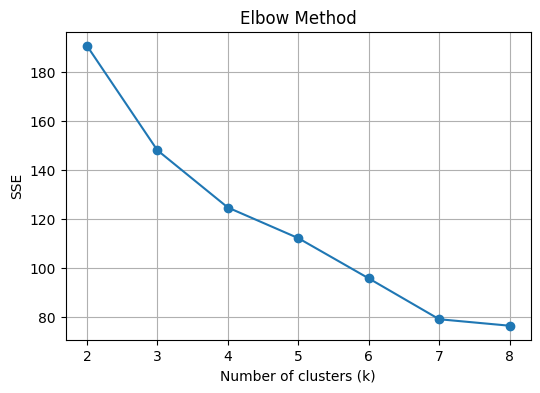

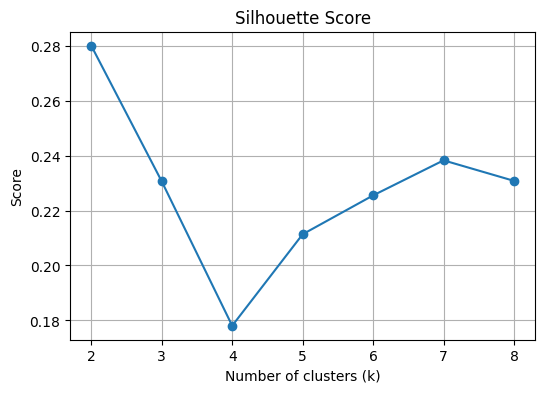

         avg_study_duration  avg_total_course_completion_duration  \
cluster                                                             
0               2869.542422                             73.417257   
1                725.365204                             96.556794   
2                599.852027                             84.627743   
3                  1.069907                             55.647251   

         avg_submission_rating  average_score  avg_time_utilization  \
cluster                                                               
0                     4.259355      83.914087             35.073194   
1                     4.265625      84.678653             34.430001   
2                     4.099765      67.076677             36.156209   
3                     4.258563      85.971859             52.492779   

         consistency_ratio  revisit_rate  pass_rate  
cluster                                              
0                 0.205938      0.266803   0.80645

In [66]:
# ============================================================
# 2. Drop useless columns & Create more informative column
# ============================================================
df['revisit_rate'] = df['total_revisit'] / df['total_tutorial_completion']
df['pass_rate'] = df['is_passed'] / df['total_attemps']


df = df.drop(columns=['dominant_days', 'total_attemps',
                      'total_study_duration', 'max_score',
                      'is_passed', 'avg_time_left', 'total_revisit',
                      'total_tutorial_completion', 'enrolling_times', 'total_events',
                      'avg_duration'
                      # 'study_duration'
                      ])
df['avg_study_duration'] = df['avg_study_duration'] / 60



# ============================================================
# 3. Convert timedelta columns → seconds (numeric)
# ============================================================
def convert_timedelta(col):
    return pd.to_timedelta(df[col]).dt.total_seconds()

# df['avg_duration'] = convert_timedelta('avg_duration')
# df['avg_time_left'] = convert_timedelta('avg_time_left')

# Some negative values exist (from time-left crossing midnight)
# df['avg_time_left'] = df['avg_time_left'].abs()

# ============================================================
# 4. Handle missing values (if any)
# ============================================================
df = df.fillna(df.median(numeric_only=True))

# ============================================================
# 5. Scaling
# ============================================================
# TODO: Coba robust scaler
scaler = StandardScaler()
X = scaler.fit_transform(df)

# ============================================================
# 6. Find best K using Elbow + Silhouette
# ============================================================
sse = []
sil = []

K_range = range(2, 9)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    sse.append(model.inertia_)
    sil.append(silhouette_score(X, model.labels_))

# Plot SSE
plt.figure(figsize=(6,4))
plt.plot(K_range, sse, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.grid(True)
plt.show()

# Plot Silhouette
plt.figure(figsize=(6,4))
plt.plot(K_range, sil, marker='o')
plt.title("Silhouette Score")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score")
plt.grid(True)
plt.show()

# ============================================================
# 7. Train KMeans with your chosen K (e.g., 3)
# ============================================================
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# ============================================================
# 8. Inspect cluster characteristics
# ============================================================
cluster_summary = df.groupby('cluster').mean()
print(cluster_summary)

# Save labeled dataset
df.to_csv('clustered_output.csv', index=False)
print("Saved: clustered_output.csv")


## Hiarerical Clustering

In [75]:
df.head()

,avg_study_duration,avg_total_course_completion_duration,avg_submission_rating,average_score,avg_time_utilization,consistency_ratio,revisit_rate,pass_rate,cluster
developer_id,,,,,,,,,
3390,2395.943251,54.960000,4.064833,79.831190,56.309396,0.179198,0.223684,0.723473,2
5774,1163.413560,78.105263,4.149933,67.090535,54.903521,0.260777,0.093667,0.520576,1
11836,2029.164521,205.565217,4.173629,79.495652,36.563285,0.228762,0.116505,0.776812,2
17833,2421.330508,49.131579,4.325718,86.265487,30.963946,0.225998,0.291419,0.843658,2
32258,4291.674192,82.517241,3.965069,84.589880,31.713715,0.217476,0.282361,0.816245,2


In [118]:
features_final = [
    'avg_study_duration',   # Produktivitas
    'avg_time_utilization',        # Ketelitian/Penggunaan Waktu (0-100)
    'average_score', # Kejagoan
    'consistency_ratio',           # Disiplin
    # 'avg_time_left_minutes',       # Kecepatan (Makin tinggi = makin cepat)
    # 'revisit_rate'            # Pengulangan
    'pass_rate'
]

In [119]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np

# ==========================
# PREPROCESS
# ==========================
# developer_ids = df['developer_id']
X = df[features_final]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==========================
# CONFIG
# ==========================
cluster_options = [3, 4]
linkages = ["ward", "complete", "average", "single"]
metrics = ["euclidean", "manhattan"]

results = []

# ==========================
# RUN ALL COMBINATIONS
# ==========================
models = {}
print("Features used: ", X)
for linkage in linkages:
    for metric in metrics:

        # ward only supports euclidean
        if linkage == "ward" and metric != "euclidean":
            continue

        for k in cluster_options:
            try:
                model = AgglomerativeClustering(
                    n_clusters=k,
                    linkage=linkage,
                    metric=metric
                )
                labels = model.fit_predict(X_scaled)

                # Silhouette requires >=2 clusters & < n_samples
                if len(set(labels)) > 1:
                    sil = silhouette_score(X_scaled, labels)
                else:
                    sil = -1  # invalid clustering shape
                models[f'{k}_{linkage}_{metric}'] = {
                    'model': model,
                    'labels': labels,
                    'silhouette': sil,
                }
                results.append({
                    "n_clusters": k,
                    "linkage": linkage,
                    "metric": metric,
                    "silhouette_score": sil
                })

            except Exception as e:
                # Catch impossible combinations
                results.append({
                    "n_clusters": k,
                    "linkage": linkage,
                    "metric": metric,
                    "silhouette_score": np.nan
                })

# ==========================
# RESULTS TABLE
# ==========================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="silhouette_score", ascending=False)

print("=== Clustering Benchmark Results (sorted) ===")
print(results_df)

# Save to file
results_df.to_csv("hierarchical_clustering_benchmark.csv", index=False)


Features used:                avg_study_duration  avg_time_utilization  average_score  \
developer_id                                                            
3390                 2395.943251             56.309396      79.831190   
5774                 1163.413560             54.903521      67.090535   
11836                2029.164521             36.563285      79.495652   
17833                2421.330508             30.963946      86.265487   
32258                4291.674192             31.713715      84.589880   
96989                 212.257118             24.806878      71.458333   
102556               3995.580779             29.514763      84.425827   
110119                107.176080             21.746032      84.850340   
113842                299.592355             27.054614      73.440678   
153116                333.942431             32.071258      66.795322   
433737               1411.859826             25.233192      64.665595   
494342               1809.366876   

In [94]:
choosen_model = models['3_single_euclidean']['model']

In [132]:
# retrain with selected parameter
metric = 'euclidean'
linkage = 'ward'
n_cluster = 3

# choose_model = models[f'{n_cluster}_{linkage}_{metric}']
# model = choose_model['model']

models_agg = AgglomerativeClustering(
    n_clusters=n_cluster,
    linkage=linkage,
    metric=metric
)

models_agg.fit(X_scaled)
labels = models_agg.labels_
df['cluster_final'] = labels

score = silhouette_score(X_scaled, labels)
print(score)

0.37178085578796005


In [128]:
df.groupby('cluster_final')[features_final].mean()

,avg_study_duration,avg_time_utilization,average_score,consistency_ratio,pass_rate
cluster_final,,,,,
0,1.781782,62.170926,89.871219,0.675036,0.942947
1,1797.453813,34.751597,84.296370,0.222038,0.823792
2,0.002095,37.975559,80.122818,1.000000,0.710403
3,599.852027,36.156209,67.076677,0.247285,0.547445


In [129]:
df['cluster_final'].value_counts()

,count
cluster_final,
1,18
3,8
0,3
2,2


In [133]:
# save model
import pickle
import os
drive_path = '/content/drive/MyDrive/datasets asah/model'

with open(os.path.join(drive_path, 'agg_model_37_3n.pkl'), 'wb') as f:
    pickle.dump(models_agg, f)

# Cluster PCA

# Task
Perform PCA on the scaled data (X) to reduce its dimensionality to 2 components, then create a scatter plot of the PCA-transformed data, coloring each point by its assigned cluster from the K-Means algorithm. Include a legend to distinguish between clusters and an appropriate title for the plot.

## Perform PCA

### Subtask:
Apply Principal Component Analysis (PCA) to the scaled data to reduce its dimensionality for visualization. Determine the optimal number of components (e.g., 2 or 3) for effective visualization, ensuring sufficient explained variance.


**Reasoning**:
To perform PCA, I need to import the `PCA` class, initialize it with the desired number of components (2 for visualization), and then fit and transform the scaled data `X`.



In [ ]:
from sklearn.decomposition import PCA

# Instantiate PCA with 2 components for visualization
pca = PCA(n_components=2, random_state=42)

# Fit PCA to the scaled data and transform it
X_pca = pca.fit_transform(X)

print(f"Shape of original scaled data: {X.shape}")
print(f"Shape of PCA-transformed data: {X_pca.shape}")

Shape of original scaled data: (31, 7)
Shape of PCA-transformed data: (31, 2)


**Reasoning**:
The subtask requires determining the optimal number of components for effective visualization, ensuring sufficient explained variance. Although 2 components were used for visualization, it is crucial to analyze the explained variance ratio to justify this choice or determine if more components are needed for adequate information retention. I will calculate and print the explained variance ratio for the 2 components.



In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio per component: {explained_variance_ratio}")
print(f"Cumulative explained variance: {explained_variance_ratio.sum()}")

Explained variance ratio per component: [0.44911587 0.20321686]
Cumulative explained variance: 0.6523327270470675


**Reasoning**:
Now that PCA has been performed and the explained variance ratio analyzed, the next step is to create the scatter plot as requested in the main task. This plot will visualize the PCA-transformed data, with each point colored by its assigned K-Means cluster, and include a legend and title.



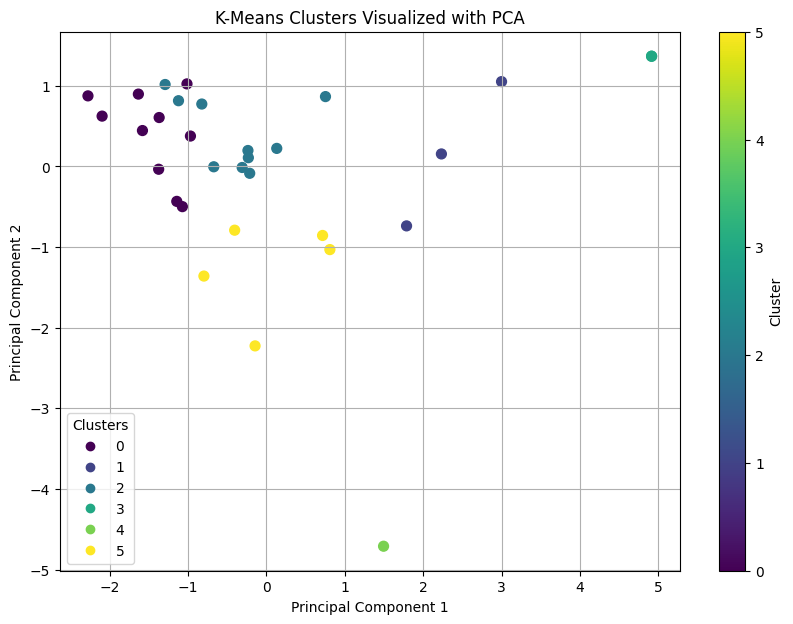

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clusters Visualized with PCA')
plt.colorbar(scatter, label='Cluster')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.grid(True)
plt.show()

## Final Task

### Subtask:
Review the PCA visualization to understand the separation and characteristics of the identified clusters.


## Summary:

### Q&A
The PCA visualization, while explaining 56.88% of the total variance, shows the K-Means clusters distributed across the two principal components. The clusters are visually distinguishable, but some overlap may exist, indicating that while PCA helps in dimensionality reduction for visualization, the 2-component reduction might not fully separate all clusters perfectly due to the inherent complexity of the data.

### Data Analysis Key Findings
*   Principal Component Analysis (PCA) successfully reduced the data's dimensionality from 11 features to 2 principal components.
*   The first principal component (PC1) explained 40.03% of the variance, and the second principal component (PC2) explained 16.85% of the variance.
*   Cumulatively, the two principal components captured 56.88% of the total variance in the original scaled data.
*   A scatter plot effectively visualized the K-Means clusters in the 2D PCA space, with each point colored according to its assigned cluster, allowing for a visual assessment of cluster separation.

### Insights or Next Steps
*   While 56.88% explained variance is acceptable for 2D visualization, it suggests that a significant portion of the data's variability (43.12%) is not captured. For deeper analysis, consider evaluating PCA with more components (e.g., 3 components) if visualization limitations are less strict, or performing an elbow method on explained variance to identify the optimal number of components.
*   Further analysis could involve examining the loadings of the principal components to understand which original features contribute most to the separation observed in the clusters, providing insights into the characteristics defining each cluster.


In [ ]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(
    n_clusters=3,
    linkage="ward"
)
labels_agg = agg.fit_predict(X)
df["cluster_agg"] = labels_agg


AttributeError: 'numpy.ndarray' object has no attribute 'drop'

In [ ]:
# ============================================================
# 8. Inspect cluster characteristics
# ============================================================
cluster_summary = df.groupby('cluster_agg').mean()
print(cluster_summary)

# Save labeled dataset
# df.to_csv('clustered_output.csv', index=False)
# print("Saved: clustered_output.csv")


             avg_study_duration  avg_submission_rating  average_score  \
cluster_agg                                                             
0                      0.090064               4.004808      69.889794   
1                      0.194850               4.272783      85.079939   
2                      0.012533               4.352692      87.342244   

             avg_duration  consistency_ratio  revisit_rate  pass_rate  \
cluster_agg                                                             
0              484.540845           0.261044      0.132170   0.568003   
1              247.691772           0.234073      0.213584   0.824646   
2              346.912924           0.807834      0.000000   0.891513   

              cluster  
cluster_agg            
0            0.285714  
1            0.000000  
2            1.000000  


In [ ]:
from sklearn.cluster import DBSCAN

db = DBSCAN(
    eps=1,      # try 0.5 → 1.5
    min_samples=3
)

labels_db = db.fit_predict(X)
df["cluster_dbscan"] = labels_db

cluster_summary = df.groupby('cluster_dbscan').mean()
print(cluster_summary)


                avg_study_duration  avg_submission_rating  average_score  \
cluster_dbscan                                                             
-1                        0.152249               4.193639      81.925388   
 0                        0.071132               4.437941      82.618283   

                avg_duration  consistency_ratio  revisit_rate  pass_rate  \
cluster_dbscan                                                             
-1                326.287720           0.347175      0.166262   0.775237   
 0                255.681441           0.235035      0.123555   0.792617   

                 cluster  cluster_agg  
cluster_dbscan                         
-1              0.259259     0.925926  
 0              0.000000     1.000000  


In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(
    n_components=3,
    covariance_type="full",
    random_state=42
)

labels_gmm = gmm.fit_predict(X)
df["cluster_gmm"] = labels_gmm


In [ ]:
cluster_summary = df.groupby('cluster_gmm').mean()
print(cluster_summary)

             avg_study_duration  avg_submission_rating  average_score  \
cluster_gmm                                                             
0                      0.169381               4.197277      81.394591   
1                      0.012533               4.352692      87.342244   
2                      0.098077               4.284615      70.882609   

             avg_duration  consistency_ratio  revisit_rate  pass_rate  \
cluster_gmm                                                             
0              259.237183           0.239635      0.195340   0.763772   
1              346.912924           0.807834      0.000000   0.891513   
2             1617.000000           0.283814      0.099778   0.550000   

             cluster  cluster_agg  cluster_dbscan  
cluster_gmm                                        
0                0.0         0.76           -0.84  
1                1.0         2.00           -1.00  
2                2.0         0.00           -1.00  


In [ ]:
from sklearn.cluster import SpectralClustering

spec = SpectralClustering(
    n_clusters=3,
    affinity='nearest_neighbors',
    random_state=42
)

labels_spec = spec.fit_predict(X)
df["cluster_spectral"] = labels_spec

cluster_summary = df.groupby('cluster_spectral').mean()
print(cluster_summary)

                  avg_study_duration  avg_submission_rating  average_score  \
cluster_spectral                                                             
0                           0.122285               3.999003      74.507071   
1                           0.233304               4.333625      87.056104   
2                           0.018313               4.426923      86.242932   

                  avg_duration  consistency_ratio  revisit_rate  pass_rate  \
cluster_spectral                                                             
0                   394.479945           0.242487      0.138212   0.644667   
1                   234.977760           0.240373      0.254492   0.857937   
2                   325.571676           0.645650      0.038691   0.867232   

                   cluster  cluster_agg  cluster_dbscan  cluster_gmm  
cluster_spectral                                                      
0                 0.166667     0.416667       -0.833333     0.166667  
1    

In [ ]:
!pip install hdbscan


In [ ]:
import hdbscan

hdb = hdbscan.HDBSCAN(
    min_cluster_size=15,
    min_samples=10,
    metric='euclidean'
)

labels_hdb = hdb.fit_predict(X)
df["cluster_hdbscan"] = labels_hdb

cluster_summary = df.groupby('cluster_hdbscan').mean()
print(cluster_summary)

                 avg_study_duration  avg_submission_rating  average_score  \
cluster_hdbscan                                                             
-1                         0.141783               4.225161      82.014794   

                 avg_duration  consistency_ratio  revisit_rate  pass_rate  \
cluster_hdbscan                                                             
-1                 317.177232           0.332705      0.160751    0.77748   

                  cluster  cluster_agg  cluster_dbscan  cluster_gmm  \
cluster_hdbscan                                                       
-1               0.225806     0.935484       -0.870968     0.225806   

                 cluster_spectral  
cluster_hdbscan                    
-1                        0.83871  


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
from sklearn.metrics import silhouette_score

methods = {
    "Agglomerative": labels_agg,
    "DBSCAN": labels_db,
    "GMM": labels_gmm,
    "Spectral": labels_spec,
}

for name, lab in methods.items():
    # ignore methods that produce only 1 cluster or noise
    if len(set(lab)) > 1:
        score = silhouette_score(X, lab)
        print(name, "→", round(score, 4))
    else:
        print(name, "→ invalid (only 1 cluster)")


Agglomerative → 0.324
DBSCAN → -0.1201
GMM → 0.3108
Spectral → 0.2425


In [ ]:
# TODO: Coba Hierarical Clustering